<a href="https://colab.research.google.com/github/fambargh/SAMPLE/blob/master/segmentationoptimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-4z7khpof
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-4z7khpof
  Created wheel for albumentations: filename=albumentations-0.4.4-cp36-none-any.whl size=61995 sha256=65e8dde35feac01936bf7ba97dec401af603e008d698a58b51844c1bb8188df0
  Stored in directory: /tmp/pip-ephem-wheel-cache-60xzzwlm/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.4
    Uninstalling albumentations-0.4.4:
      Successfully uninstalled albumentations-0.4.4


In [15]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
#!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

Requirement already up-to-date: segmentation-models in /root/.local/lib/python3.6/site-packages (1.0.0)


In [4]:
from zipfile import ZipFile
filename = "image.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
from zipfile import ZipFile
filename = "annotate_cup.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
x_train_dir = '/content/image_train/'
y_train_dir = '/content/annotate_cup_train/'

x_valid_dir = '/content/image_valid/'
y_valid_dir = '/content/annotate_cup_valid'

x_test_dir = '/content/image_test/'
y_test_dir = '/content/annotate_cup_test/'

In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['0', '255']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

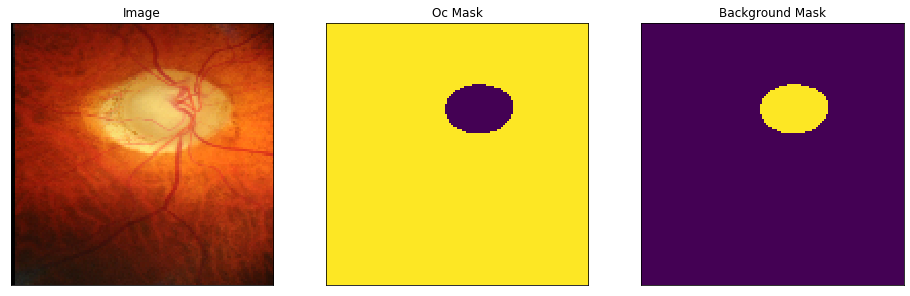

In [5]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['0','255'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    #sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

In [0]:
import albumentations as A


In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        A.RandomCrop(height=128, width=128, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(128, 128)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


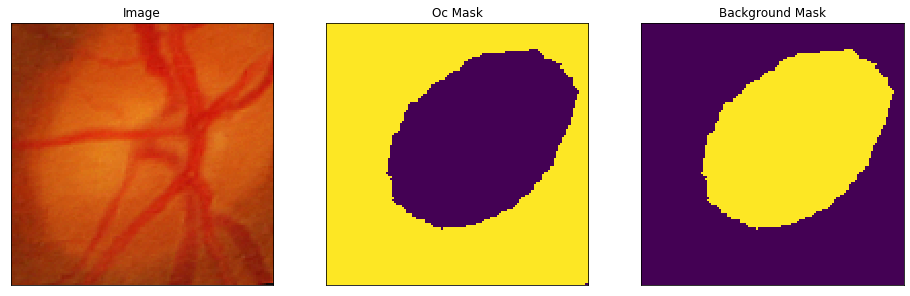

In [8]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['0', '255'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    #sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

In [9]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [0]:
BACKBONE = 'seresnet50'
BATCH_SIZE = 8
CLASSES = ['0','255']
#LR = 0.01
EPOCHS = 2

preprocess_input = sm.get_preprocessing(BACKBONE)

In [0]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

In [12]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128, 128, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 128, 128, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


Epoch 1/2
22/22 [==============================] - 73s 3s/step - loss: 1.4860 - iou_score: 0.2339 - f1-score: 0.3243 - val_loss: 1.2322 - val_iou_score: 0.3236 - val_f1-score: 0.3826
Epoch 2/2
22/22 [==============================] - 5s 226ms/step - loss: 1.1768 - iou_score: 0.3550 - f1-score: 0.4506 - val_loss: 1.0900 - val_iou_score: 0.3963 - val_f1-score: 0.4488
Epoch 1/2
22/22 [==============================] - 78s 4s/step - loss: 1.3566 - iou_score: 0.4127 - f1-score: 0.5003 - val_loss: 1.1160 - val_iou_score: 0.6678 - val_f1-score: 0.7242
Epoch 2/2
22/22 [==============================] - 5s 237ms/step - loss: 0.9479 - iou_score: 0.7088 - f1-score: 0.7896 - val_loss: 1.5382 - val_iou_score: 0.6773 - val_f1-score: 0.7248
Epoch 1/2
22/22 [==============================] - 82s 4s/step - loss: 1.2252 - iou_score: 0.6189 - f1-score: 0.7097 - val_loss: 1.5208 - val_iou_score: 0.6594 - val_f1-score: 0.6998
Epoch 2/2
22/22 [==============================] - 6s 251ms/step - loss: 1.0327 -

ValueError: ignored

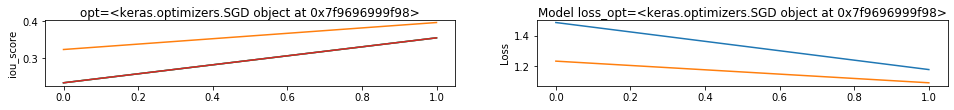

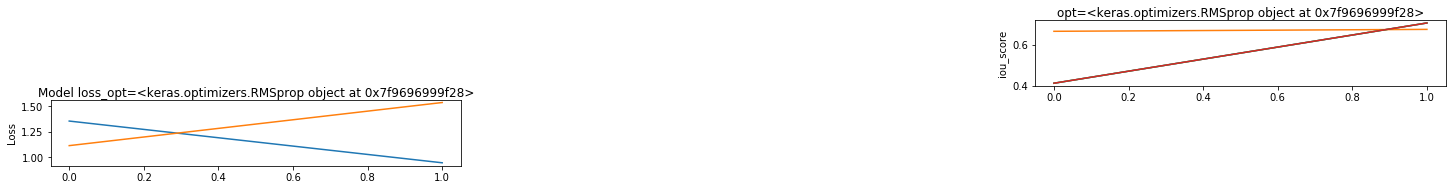

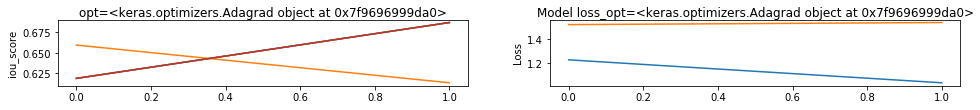

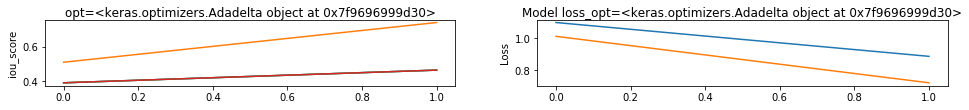

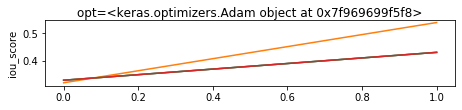

In [21]:
# study of learning rate on accuracy for blobs problem
from sklearn.datasets.samples_generator import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adagrad,Adadelta, Adam, Adamax, Nadam
from keras.utils import to_categorical
from matplotlib import pyplot



# fit a model and plot learning curve
def fit_model(train_data, validimage, opt):
  # define model
  # define network parameters
  n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
  activation = 'sigmoid' if n_classes == 1 else 'softmax'
  model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
  #opt = SGD(lr=opt)
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss() 
  total_loss = dice_loss + (1 * focal_loss)
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
  model.compile(opt, total_loss, metrics)
  ##model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  # fit model
  history = model.fit_generator(train_dataloader, 
                                steps_per_epoch=len(train_data), 
                                epochs=EPOCHS, 
                                #callbacks=callbacks, 
                                validation_data=validimage, 
                                validation_steps=len(validimage),
                                )
  ###history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
  # plot learning curves
  ###plt.plot(history.history[])
  pyplot.subplot(plot_no1)
  pyplot.plot(history.history['iou_score'], label='train')
  pyplot.plot(history.history['val_iou_score'], label='test')
  pyplot.plot(history.history['iou_score'], label='train')
  pyplot.plot(history.history['iou_score'], label='train')
  pyplot.title('opt='+str(opt), pad=-50)
  plt.ylabel('iou_score')
  pyplot.subplot(plot_no2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  #plt.title('Model loss')
  plt.ylabel('Loss')
  pyplot.title('Model loss_opt='+str(opt), pad=-50)


# prepare dataset
###trainX, trainy, testX, testy = prepare_data()
# create learning curves for different learning rates
#learning_rates = [ 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6]
optimum = [SGD(lr=0.01, momentum=0.0, nesterov=False), RMSprop(lr=0.001, rho=0.9), Adagrad(lr=0.01), Adadelta(lr=1.0, rho=0.95), Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), Adamax(lr=0.002, beta_1=0.9, beta_2=0.999), Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)]
#optimum = [SGD(lr=0.01, momentum=0.0, nesterov=False), Adam(lr=0.001, beta_1=0.9, beta_2=0.999), RMSprop(lr=0.001, rho=0.9)]
for i in range(len(optimum)):
	# determine the plot number
  plt.figure(figsize=(25, 10))
  plot_no1 = 730+(2*i+1)
  #plot_no2=820+(i+len(optimum))
  plot_no2 = 730+(2*i+2)

  # fit model and plot learning curves for a learning rate
  fit_model(train_dataloader, valid_dataloader, optimum[i])

# show learning curves
pyplot.show()
# define network parameters
####activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
###model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
22/22 [==============================] - 23s 1s/step - loss: 1.5548 - iou_score: 0.1914 - f1-score: 0.2743 - val_loss: 1.2500 - val_iou_score: 0.3316 - val_f1-score: 0.4001
Epoch 2/2
22/22 [==============================] - 4s 186ms/step - loss: 1.1808 - iou_score: 0.3343 - f1-score: 0.4271 - val_loss: 1.0667 - val_iou_score: 0.6288 - val_f1-score: 0.6843
Epoch 1/2
22/22 [==============================] - 23s 1s/step - loss: 1.2321 - iou_score: 0.3654 - f1-score: 0.4515 - val_loss: 11.0122 - val_iou_score: 0.1167 - val_f1-score: 0.1722
Epoch 2/2
22/22 [==============================] - 4s 195ms/step - loss: 0.9378 - iou_score: 0.4824 - f1-score: 0.5602 - val_loss: 0.7664 - val_iou_score: 0.7559 - val_f1-score: 0.8035
Epoch 1/2
22/22 [==============================] - 25s 1s/step - loss: 1.2677 - iou_score: 0.5308 - f1-score: 0.6189 - val_loss: 0.9948 - val_iou_score:

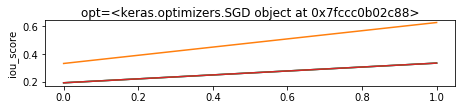

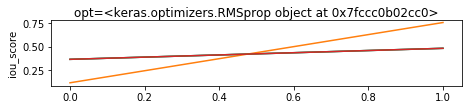

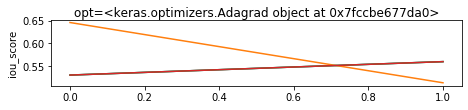

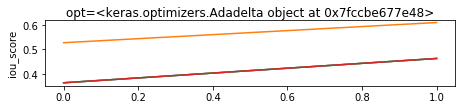

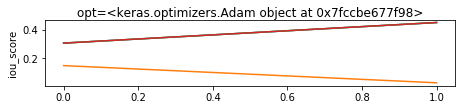

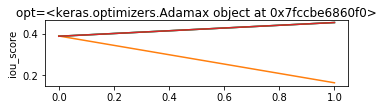

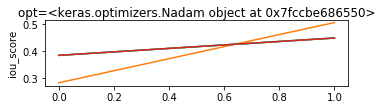

In [13]:
# study of learning rate on accuracy for blobs problem
from sklearn.datasets.samples_generator import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adagrad,Adadelta, Adam, Adamax, Nadam
from keras.utils import to_categorical
from matplotlib import pyplot



# fit a model and plot learning curve
def fit_model(train_data, validimage, opt):
  # define model
  # define network parameters
  n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
  activation = 'sigmoid' if n_classes == 1 else 'softmax'
  model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
  #opt = SGD(lr=opt)
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss() 
  total_loss = dice_loss + (1 * focal_loss)
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
  model.compile(opt, total_loss, metrics)
  ##model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  # fit model
  history = model.fit_generator(train_dataloader, 
                                steps_per_epoch=len(train_data), 
                                epochs=EPOCHS, 
                                #callbacks=callbacks, 
                                validation_data=validimage, 
                                validation_steps=len(validimage),
                                )
  ###history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
  # plot learning curves
  ###plt.plot(history.history[])
  
  pyplot.plot(history.history['iou_score'], label='train')
  pyplot.plot(history.history['val_iou_score'], label='test')
  pyplot.plot(history.history['iou_score'], label='train')
  pyplot.plot(history.history['iou_score'], label='train')
  pyplot.title('opt='+str(opt), pad=-50)
  plt.ylabel('iou_score')
 # pyplot.subplot(plot_no2)
  #plt.plot(history.history['loss'])
  #plt.plot(history.history['val_loss'])
  #plt.title('Model loss')
 # plt.ylabel('Loss')
  #pyplot.title('Model loss_opt='+str(opt), pad=-50)


# prepare dataset
###trainX, trainy, testX, testy = prepare_data()
# create learning curves for different learning rates
#learning_rates = [ 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6]
optimum = [SGD(lr=0.01, momentum=0.0, nesterov=False), RMSprop(lr=0.001, rho=0.9), Adagrad(lr=0.01), Adadelta(lr=1.0, rho=0.95), Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), Adamax(lr=0.002, beta_1=0.9, beta_2=0.999), Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)]
#optimum = [SGD(lr=0.01, momentum=0.0, nesterov=False), Adam(lr=0.001, beta_1=0.9, beta_2=0.999), RMSprop(lr=0.001, rho=0.9)]
for i in range(len(optimum)):
	# determine the plot number
  plt.figure(figsize=(25, 10))
  plot_no1 = 730+(2*i+1)
  pyplot.subplot(plot_no1)
  #plot_no2=820+(i+len(optimum))
  #plot_no2 = 730+(2*i+2)

  # fit model and plot learning curves for a learning rate
  fit_model(train_dataloader, valid_dataloader, optimum[i])

# show learning curves
pyplot.show()
# define network parameters
####activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
###model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [0]:
# define optomizer
###optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
####dice_loss = sm.losses.DiceLoss()
####focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
#####total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

####metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
###model.compile(optim, total_loss, metrics)

In [0]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

In [0]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [0]:
# load best weights
model.load_weights('best_model.h5')

In [0]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [0]:
n = 20
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
